In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import matplotlib.pyplot as plt
import pathlib
from scipy.optimize import curve_fit
import ipywidgets as widgets
from IPython.display import display
from traitlets import traitlets
import numpy as np
import statistics as stat
import scipy.signal as sig
from scipy.signal import savgol_filter

%matplotlib inline

In [1]:
'''Raw Data Functions'''

'''Import raw traces from data columns in text file'''
def importRawData(filepath,usecols=(1,2)):
    
    #generate array from text file
    arr = np.genfromtxt(filepath,delimiter='', skip_header = 15, usecols=usecols) 
    
    ch1_raw = arr.T[0] #YbOH
    ch2_raw = arr.T[1] #Yb
    raw_data = [ch1_raw,ch2_raw]
    
    return raw_data

'''Grab trace parameters from cleverscope text file'''
def importCleverParams(filepath):
    with open(filepath, 'r') as f:
        lines=[]
        for i in range(15):
            lines.append(f.readline())
    params=[]
    for text in lines:
        if 'delta' in text:
            dt_ms = float(text.split('\t')[1].strip())*10**3
            params.append(dt_ms)
        elif 'start' in text:
            start_ms = float(text.split('\t')[1].strip())*10**3
            params.append(start_ms)
        elif 'nsample' in text:
            nsample = int(float(text.split('\t')[1].strip()))
            params.append(nsample)
        elif 'TriggerTime' in text:
            time_sec = float(text.split('\t')[1].strip())*24*3600 #convert days to seconds
            params.append(time_sec)
    return params
        
'''Generate filepath'''
def genPath(root_folder,num):
    num_str = str(num)
    name = 'spectra_'
    file =  name + num_str + '.txt'
    #path is given from current working directory
    filepath = pathlib.Path.cwd() / root_folder / file
    return filepath

'''Convert Cleverscope file to dataset with raw data and associated parameters'''
def file2dataset(root_folder,num,print_bool=False):
    filepath = genPath(root_folder,num)
    if print_bool:
        print(filepath)
    data = importRawData(filepath)
    parameters = importCleverParams(filepath)
    dataset = [data,parameters]
    return dataset

def getRawDataset(folder_path,start_num,stop_num,print_bool):
    stop_num+=1
    blocked_YbOH_raw = [] #ch1
    blocked_Yb_raw = [] #ch2
    blocked_params = []
    unblocked_YbOH_raw = []
    unblocked_Yb_raw = []
    unblocked_params=[]
    
    blocked = False
    
    progress = widgets.FloatProgress(value=0.0, min=0.0, max=1.0)
    display(progress)
    for i in range(start_num,stop_num):
        if blocked:
            data,params = file2dataset(folder_path,i,print_bool)
            params.append(blocked)
            blocked_YbOH_raw.append(data[0])
            blocked_Yb_raw.append(data[1])
            blocked_params.append(params)
            blocked = False
        elif not blocked:
            data,params = file2dataset(folder_path,i,print_bool)
            params.append(blocked)
            unblocked_YbOH_raw.append(data[0])
            unblocked_Yb_raw.append(data[1])
            unblocked_params.append(params)
            blocked = True
        progress.value = float(i-start_num+1)/(stop_num-start_num)
    blocked_dataset = [blocked_YbOH_raw, blocked_Yb_raw, blocked_params]
    unblocked_dataset = [unblocked_YbOH_raw, unblocked_Yb_raw, unblocked_params]
    return [blocked_dataset,unblocked_dataset]
    
def wrapper_getRawDataset(w):
        print('Generating raw data from ',folder_path_w.value)
        #results = processData(folder_path_w.value,start_num_w.value,stop_num_w.value,start_setpnt_w.value,stop_setpnt_w.value,setpnt_int_w.value,print_w.value)
        results = getRawDataset(folder_path_w.value,start_num_w.value,stop_num_w.value,print_w.value)
        w.value = results
        print('Done')
        
        
###############################################################################################################################################################################        


'''Data Processing Functions'''
    
'''Convert raw absorption data into optical depth'''
def raw2OD(raw,time_ms):
    trigger_index = np.searchsorted(time_ms,0)
    beforeYAG_index = np.searchsorted(time_ms,-0.1)
    
    #Calculate DC offset, convert signal to OD
    offset = raw[:beforeYAG_index].mean()
    
    #Smooth the data
    smoothed_data = smooth(raw,window=60)
    
    #Calculate OD, fix floating point errors
    OD = np.log(offset/smoothed_data)
    
    if OD[trigger_index]<0:
        offset = smoothed_data[trigger_index]
        OD = np.log(offset/smoothed_data)
    
    return OD

#def file2OD(root_folder,num,print_bool):

'''Function for smoothing data. Currently uses Savitzky-Golay filter, which fits a window 
    onto a polynomial of some order, and then uses the polynomial to estimate the value'''
def smooth(data,window=5,poly_order=3):
    
    #window value must be odd
    if window % 2 == 0:
        window+=1
    smoothed_data = savgol_filter(data, window, poly_order)     
    return smoothed_data

#Not used anymore. Only useful if there is linear drift
def subtractBackground(raw,time):
    end = len(cell_abs)
    start = 5000
    t = slice(start,end)
    offset = -1.8486
    num_avg = 900
    time_ms = np.round(np.linspace(offset,dt*(end-1)+offset,end),decimals = 6)
    b_guess = cell_abs[:num_avg].sum()/num_avg
    m_guess = 0
    abs_slice = cell_abs[t]
    time_slice = time_ms[t]
    params = fitLine(time_slice,abs_slice,guess=[m_guess,b_guess])
    background = line(time_ms,*params)
    cell_OD = np.log(background/cell_abs)
    #cell_OD[cell_OD<0]=0
    return cell_OD

def timeArray(dt,t0,npnts):
    time_ms = np.round(np.linspace(t0,dt*(npnts-1)+t0,npnts),decimals = 6)
    return time_ms

def calculateODs(blocked_dataset,unblocked_dataset,skips=[],print_bool=True):
    
    time_length = len(blocked_dataset[0][0])
    num_skips = len(skips)
    num_traces = len(blocked_dataset[0]) - num_skips
    
    blocked_YbOH_OD = np.zeros((num_traces,time_length))
    unblocked_YbOH_OD = np.zeros((num_traces,time_length))
    blocked_Yb_OD = np.zeros((num_traces,time_length))
    unblocked_Yb_OD = np.zeros((num_traces,time_length))
    unblocked_params = []
    blocked_params = []
        
    plt.figure(1)
    plt.title('Blocked YbOH OD')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')

    plt.figure(2)
    plt.title('Unblocked YbOH OD')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')
    
    plt.figure(3)
    plt.title('Blocked Yb OD')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')
    
    plt.figure(4)
    plt.title('Unblocked Yb OD')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')

    progress = widgets.FloatProgress(value=0.0, min=0.0, max=1.0)
    display(progress)
    for dataset in [blocked_dataset,unblocked_dataset]:
        YbOH = dataset[0]
        Yb = dataset[1]
        params = dataset[2]
        for i in range(num_traces):
            if i in skips:
                pass
            else:
                time_ms = timeArray(*params[i][0:3])
                YbOH_OD = raw2OD(YbOH[i],time_ms)
                Yb_OD = raw2OD(Yb[i],time_ms)
                blocked = params[i][4]
                if blocked:
                    plt.figure(1)
                    plt.plot(time_ms,YbOH_OD)
                    plt.figure(3)
                    plt.plot(time_ms,Yb_OD)
                    blocked_params.append(params[i])
                    for j in range(time_length):
                        blocked_YbOH_OD[i][j]=YbOH_OD[j]
                        blocked_Yb_OD[i][j]=Yb_OD[j]
                elif not blocked:
                    plt.figure(2)
                    plt.plot(time_ms,YbOH_OD)
                    plt.figure(4)
                    plt.plot(time_ms,Yb_OD)
                    unblocked_params.append(params[i])
                    for j in range(time_length):
                        unblocked_YbOH_OD[i][j]=YbOH_OD[j]
                        unblocked_Yb_OD[i][j]=Yb_OD[j]
            progress.value = float(i)/(num_traces-1)
    blocked_ODs = [blocked_YbOH_OD, blocked_Yb_OD,blocked_params]
    unblocked_ODs = [unblocked_YbOH_OD, unblocked_Yb_OD,unblocked_params]
    
    return [blocked_ODs, unblocked_ODs]

def wrapper_calcODs(w):
        print('Calculating ODs from ',folder_path_w.value)
        #results = processData(folder_path_w.value,start_num_w.value,stop_num_w.value,start_setpnt_w.value,stop_setpnt_w.value,setpnt_int_w.value,print_w.value)
        results = calculateODs(*rawdata_lb.value, print_bool=print_w.value)
        w.value = results
        print('Done')
        return

    
##########################################################################################################################################

'''Enhancement vs Power'''

def sliceIntegrate(OD,time_ms,start_time,stop_time,print_bool,fig_num):
    start_i = np.searchsorted(time_ms,start_time)
    stop_i = np.searchsorted(time_ms,stop_time)
    t = slice(start_i,stop_i)
    dt = np.round(time_ms[1]-time_ms[0],decimals=6)
    integrated = np.round(OD[t].sum()*dt,decimals=6)
    if True:
        plt.figure(fig_num)
        plt.plot(time_ms[t],OD[t])
    return integrated

power = [
        235.0,
        70.0,
        432.0,
        150.0,
        370.0,
        552.0,
        552.1,
        425.0,
        425.1,
        48.0,
        48.1,
        187.0,
        490.0,
        604.0,
        725.0,
        314.0,
        254.0,
        161.0,
        379.0,
        121.0,
        65.0,
        440.0
    ]

def integrateODs(blocked_ODs, unblocked_ODs,start_int,stop_int,spectrum=power,print_bool=True):
    
    num_traces = len(spectrum)
    
    blocked_YbOH_int = np.zeros(num_traces)
    blocked_Yb_int = np.zeros(num_traces)
    unblocked_YbOH_int = np.zeros(num_traces)
    unblocked_Yb_int = np.zeros(num_traces)
    YbOH_enhancement = np.zeros(num_traces)
    Yb_enhancement = np.zeros(num_traces)
    
    plt.figure(1)
    plt.title('Blocked YbOH OD')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')

    plt.figure(2)
    plt.title('Unblocked YbOH OD')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')
    
    plt.figure(3)
    plt.title('Blocked Yb OD')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')
    
    plt.figure(4)
    plt.title('Unblocked Yb OD')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')
    
    progress = widgets.FloatProgress(value=0.0, min=0.0, max=1.0)
    display(progress)
    for dataset in [blocked_ODs, unblocked_ODs]:
        YbOH_OD = dataset[0]
        Yb_OD = dataset[1]
        params = dataset[2]
        for i in range(num_traces):
            time_ms = timeArray(*params[i][0:3])
            blocked = params[i][4]
            if blocked:
                blocked_YbOH_int[i] = sliceIntegrate(YbOH_OD[i],time_ms,start_int,stop_int,print_bool,1)
                blocked_Yb_int[i] = sliceIntegrate(Yb_OD[i],time_ms,start_int,stop_int,print_bool,3)
            elif not blocked:
                unblocked_YbOH_int[i] = sliceIntegrate(YbOH_OD[i],time_ms,start_int,stop_int,print_bool,2)
                unblocked_Yb_int[i] = sliceIntegrate(Yb_OD[i],time_ms,start_int,stop_int,print_bool,4)
            progress.value = float(i)/(num_traces-1)
    for i in range(num_traces):
        YbOH_enhancement[i] = unblocked_YbOH_int[i]/blocked_YbOH_int[i]
        Yb_enhancement[i] = unblocked_Yb_int[i]/blocked_Yb_int[i]
    
    YbOH_enhancement_sorted = [OD for value,OD in sorted(zip(spectrum,YbOH_enhancement))]
    Yb_enhancement_sorted = [OD for value,OD in sorted(zip(spectrum,Yb_enhancement))]
    #blocked_OD_sorted = [OD for power,OD in sorted(zip(power_556,blocked_OD))]
    #unblocked_OD_sorted = [OD for power,OD in sorted(zip(power_556,unblocked_OD))]
    spectrum_sorted = sorted(spectrum)
    return [YbOH_enhancement_sorted, Yb_enhancement_sorted, spectrum_sorted]
            
def wrapper_intODs(w):
        print('Integrating and processing ODs from ',folder_path_w.value)
        results = integrateODs(*calcODs_lb.value, start_int=start_int_w.value,stop_int=stop_int_w.value, print_bool=print_w.value)
        w.value = results
        print('Done')
        
        
        
#########################################################################################################################################################


'''Fitting Functions'''
                       
def gaussian(x,a,b,n,c):
    value= n*np.exp(-(x-b)**2/(2*a**2))+c
    return value

def line(x,m,b):
    value = m*x+b
    return value

def fitLine(xscale, data,guess=[1,0]):
    try:
        popt,pcov = curve_fit(line,xscale,data,p0=guess)
    except RuntimeError:
        print("Error - curve_fit failed")
        popt = []
    perr = np.round(np.sqrt((np.diag(pcov))),decimals=6)
    popt = np.round(popt,decimals=6)
    print('Slope = {}'.format(popt[0]))
    return popt

def twoGaussians(x,a1,a2,b1,b2,n1,n2,c=0):
    params1 = [a1,b1,n1,c]
    params2 = [a2,b2,n2,c]
    total = gaussian(x,*params1)+gaussian(x,*params2)
    return total

def threeGaussians(x,a1,a2,a3,b1,b2,b3,n1,n2,n3,c=0):
    params1 = [a1,b1,n1,c]
    params2 = [a2,b2,n2,c]
    params3 = [a3,b3,n3,c]
    total = gaussian(x,*params1)+gaussian(x,*params2)+gaussian(x,*params3)
    return total
    
def fitGaussian(xscale, data,guess=[100,0,0.16,0],sigma=None):
    try:
        popt, pcov = curve_fit(gaussian, xscale, data,p0=guess,sigma=sigma,bounds=([20.0,-np.inf,-np.inf,0],[np.inf,np.inf,np.inf,np.inf]))
    except RuntimeError:
        print("Error - curve_fit failed")
        popt = []
    print('Standard Dev = ',popt[0])
    print('Covariance matrix = \n',pcov)
    perr = np.round(np.sqrt((np.diag(pcov))),decimals=3)
    popt = np.round(popt,decimals=3)
    print('Fit error = ',perr)
    print('FIT PARAMS = ',popt)
    print('\n\n')
    print('Mean = {} +/- {} MHz, StDev = {} +/- {} MHz'.format(popt[1],perr[1],popt[0],perr[0]))
    return popt
        
def fit3Gaussians(xscale, data,mean_guess,stdev_guess,norm_guess,offset_guess=None):
    guess = stdev_guess + mean_guess + norm_guess+offset_guess
    print(guess)
    try:
        popt, pcov = curve_fit(threeGaussians, xscale, data,p0=guess)
    except RuntimeError:
        print("Error - curve_fit failed")
        popt = []
    #print('Covariance matrix = \n',pcov)
    perr = np.round(np.sqrt((np.diag(pcov))),decimals=3)
    popt = np.round(popt,decimals=3)
    print('Fit error = ',perr)
    print('FIT PARAMS = ',popt)
    print('\n')
    print('\n')
    for i in range(3):
        peaknum = i+1
        mean = popt[3+i]
        mean_err = perr[3+i]
        stdev = popt[i]
        stdev_err = perr[i]
        print('Mean {} = {} +/- {} MHz, StDev {} = {} +/- {} MHz'.format(peaknum,mean,mean_err,peaknum,stdev,stdev_err))
    return popt

def fit2Gaussians(xscale, data,mean_guess,stdev_guess,norm_guess,offset_guess=None):
    guess = stdev_guess + mean_guess + norm_guess+offset_guess
    print(guess)
    try:
        popt, pcov = curve_fit(twoGaussians, xscale, data,p0=guess)
    except RuntimeError:
        print("Error - curve_fit failed")
        popt = []
    #print('Covariance matrix = \n',pcov)
    perr = np.round(np.sqrt((np.diag(pcov))),decimals=3)
    popt = np.round(popt,decimals=3)
    print('Fit error = ',perr)
    print('FIT PARAMS = ',popt)
    print('\n')
    print('\n')
    for i in range(2):
        peaknum = i+1
        mean = popt[2+i]
        mean_err = perr[2+i]
        stdev = popt[i]
        stdev_err = perr[i]
        print('Mean {} = {} +/- {} MHz, StDev {} = {} +/- {} MHz'.format(peaknum,mean,mean_err,peaknum,stdev,stdev_err))
    return popt




#################################################################################################################################



'''Widgets'''

style = {'description_width': 'initial'}

class LoadedButton(widgets.Button):
    """A button that can holds a value as a attribute."""

    def __init__(self, value=None, *args, **kwargs):
        super(LoadedButton, self).__init__(*args, **kwargs,style=style)
        # Create the value attribute.
        self.add_traits(value=traitlets.Any(value))

folder_path_w = widgets.Text(
    value='20181213',
    placeholder='This Notebook Directory/...',
    description='Folder path',
    disabled=False,
    style=style
)
start_num_w = widgets.IntText(
    value=20,
    description='Starting File',
    disabled=False,
    style=style
)
stop_num_w = widgets.IntText(
    value=63,
    description='Ending File',
    disabled=False,
    style=style
)
start_int_w = widgets.FloatText(
    value=0.00,
    description='Integration Start (ms)',
    disabled=False,
    style=style
)
stop_int_w = widgets.FloatText(
    value=4,
    description='Integration End (ms)',
    disabled=False,
    style=style
)

print_w = widgets.Checkbox(
    value=False,
    description='Print Output?',
    disabled=False
)



# go_button = widgets.Button(
#     description='Generate Raw Dataset',
#     disabled=False,
#     button_style='', # 'success', 'info', 'warning', 'danger' or ''
#     tooltip='Click me',
# )

NameError: name 'widgets' is not defined

In [9]:
rawdata_lb = LoadedButton(description="Get Raw Dataset", value=[])
rawdata_lb.on_click(wrapper_getRawDataset)
calcODs_lb = LoadedButton(description="Calculate ODs", value=[])
calcODs_lb.on_click(wrapper_calcODs)
intODs_lb = LoadedButton(description="Integrate ODs", value=[])
intODs_lb.on_click(wrapper_intODs)

In [10]:
r0=widgets.HBox([folder_path_w])
r1 = widgets.HBox([start_num_w,stop_num_w])
r2 = widgets.HBox([rawdata_lb,print_w])
widgets.VBox([r0,r1,r2])

A Jupyter Widget

Generating raw data from  20181213


A Jupyter Widget

Done


A Jupyter Widget

Calculating ODs from  20181213


A Jupyter Widget

Done


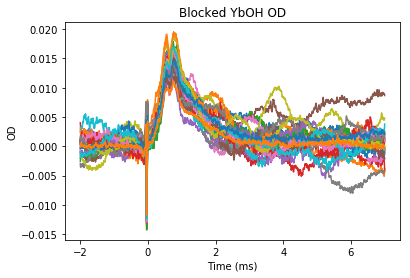

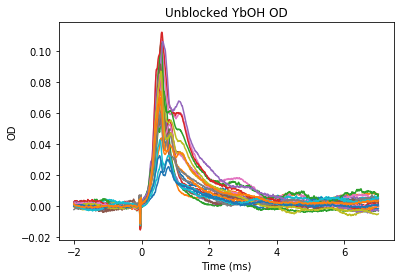

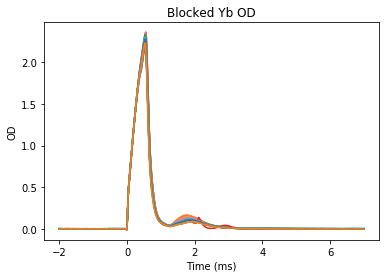

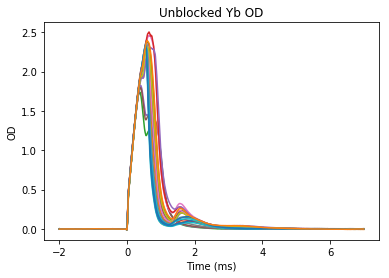

In [13]:
widgets.HBox([calcODs_lb,print_w])

A Jupyter Widget

Integrating and processing ODs from  20181213


A Jupyter Widget

Done


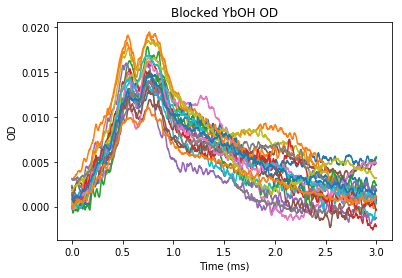

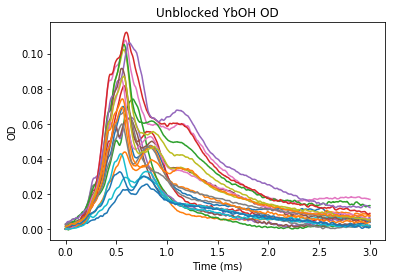

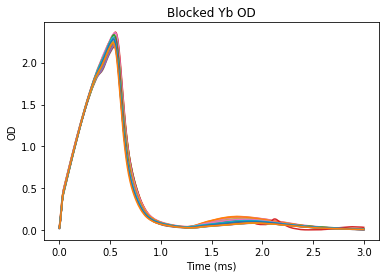

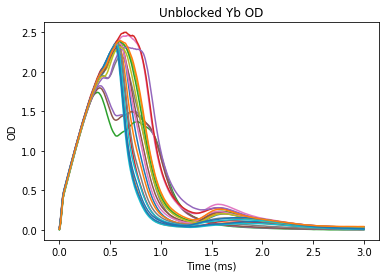

In [12]:
r4 = widgets.HBox([start_int_w,stop_int_w])
r5 = widgets.HBox([intODs_lb,print_w])
widgets.VBox([r4,r5])

In [14]:
data = intODs_lb.value

In [15]:
power_556=np.array(data[2])
enhancement_YbOH=data[0]
enhancement_Yb=data[1]

In [16]:
delete_i = [np.searchsorted(power_556,val) for val in [552,425,48,432]]
power = np.delete(power_556,delete_i)
en_YbOH = np.delete(enhancement_YbOH,delete_i)
en_Yb = np.delete(enhancement_Yb,delete_i)

Slope = 0.008674


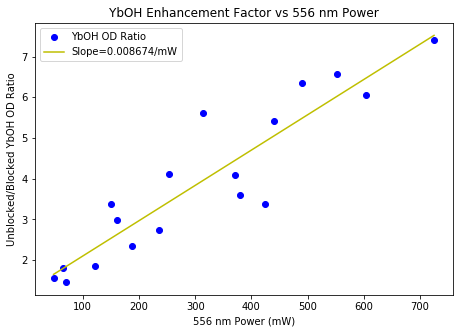

In [17]:
plt.figure(figsize=(7.5,5))
plt.plot(power,en_YbOH,'bo',label='YbOH OD Ratio')
plt.title('YbOH Enhancement Factor vs 556 nm Power')
plt.xlabel('556 nm Power (mW)')
plt.ylabel('Unblocked/Blocked YbOH OD Ratio')
params = fitLine(np.array(power),en_YbOH)
plt.plot(power,line(power,*params),'y',label='Slope={}/mW'.format(params[0]))
plt.legend(loc='best');

Slope = 0.001135


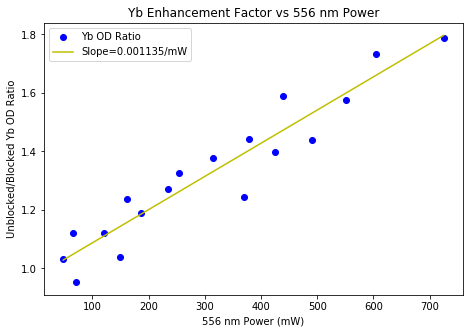

In [18]:
plt.figure(figsize=(7.5,5))
plt.plot(power,en_Yb,'bo',label='Yb OD Ratio')
plt.title('Yb Enhancement Factor vs 556 nm Power')
plt.xlabel('556 nm Power (mW)')
plt.ylabel('Unblocked/Blocked Yb OD Ratio')
params = fitLine(np.array(power),en_Yb)
plt.plot(power,line(power,*params),'y',label='Slope={}/mW'.format(params[0]))
plt.legend(loc='best');

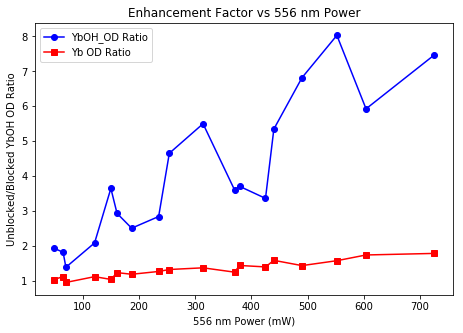

In [316]:
plt.figure(figsize=(7.5,5))
plt.plot(power,en_YbOH,'bo-',label='YbOH_OD Ratio')
plt.plot(power,en_Yb,'rs-',label='Yb OD Ratio')
plt.title('Enhancement Factor vs 556 nm Power')
plt.xlabel('556 nm Power (mW)')
plt.ylabel('Unblocked/Blocked YbOH OD Ratio')
plt.legend(loc='best');

In [223]:
norm_enhancement=[]
for i in range(len(enhancement_YbOH)):
    norm_enhancement.append(enhancement_YbOH[i]/enhancement_Yb[i])

Slope = 0.003761


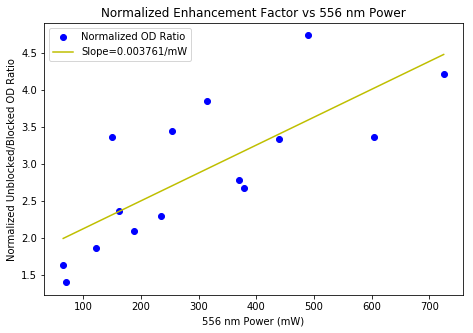

In [227]:
plt.figure(figsize=(7.5,5))
plt.plot(power_556,norm_enhancement,'bo',label='Normalized OD Ratio')
plt.title('Normalized Enhancement Factor vs 556 nm Power')
plt.xlabel('556 nm Power (mW)')
plt.ylabel('Normalized Unblocked/Blocked OD Ratio')
plt.legend(loc='best');
params = fitLine(np.array(power_556),norm_enhancement)
plt.plot(power_556,line(power_556,*params),'y',label='Slope={}/mW'.format(params[0]))
plt.legend(loc='best');

In [27]:
'''Raw Data Functions'''

'''Import raw traces from data columns in text file'''
def importRawData(filepath,usecols=(1,2)):
    
    #generate array from text file
    arr = np.genfromtxt(filepath,delimiter='', skip_header = 15, usecols=usecols) 
    
    ch1_raw = arr.T[0] #YbOH
    ch2_raw = arr.T[1] #Yb
    raw_data = [ch1_raw,ch2_raw]
    
    return raw_data

'''Grab trace parameters from cleverscope text file'''
def importCleverParams(filepath):
    with open(filepath, 'r') as f:
        lines=[]
        for i in range(15):
            lines.append(f.readline())
    params=[]
    for text in lines:
        if 'delta' in text:
            dt_ms = float(text.split('\t')[1].strip())*10**3
            params.append(dt_ms)
        elif 'start' in text:
            start_ms = float(text.split('\t')[1].strip())*10**3
            params.append(start_ms)
        elif 'nsample' in text:
            nsample = int(float(text.split('\t')[1].strip()))
            params.append(nsample)
        elif 'TriggerTime' in text:
            time_sec = float(text.split('\t')[1].strip())*24*3600 #convert days to seconds
            params.append(time_sec)
    return params
        
'''Generate filepath'''
def genPath(root_folder,num):
    num_str = str(num)
    name = 'spectra_'
    file =  name + num_str + '.txt'
    #path is given from current working directory
    filepath = pathlib.Path.cwd() / root_folder / file
    return filepath

'''Convert Cleverscope file to dataset with raw data and associated parameters'''
def file2dataset(root_folder,num,print_bool=False):
    filepath = genPath(root_folder,num)
    if print_bool:
        print(filepath)
    data = importRawData(filepath)
    parameters = importCleverParams(filepath)
    dataset = [data,parameters]
    return dataset

def getRawDataset(folder_path,start_num,stop_num,print_bool):
    stop_num+=1
    blocked_YbOH_raw = [] #ch1
    blocked_Yb_raw = [] #ch2
    blocked_params = []
    unblocked_YbOH_raw = []
    unblocked_Yb_raw = []
    unblocked_params=[]
    
    blocked = False
    
    progress = widgets.FloatProgress(value=0.0, min=0.0, max=1.0)
    display(progress)
    for i in range(start_num,stop_num):
        if blocked:
            data,params = file2dataset(folder_path,i,print_bool)
            params.append(blocked)
            blocked_YbOH_raw.append(data[0])
            blocked_Yb_raw.append(data[1])
            blocked_params.append(params)
            blocked = False
        elif not blocked:
            data,params = file2dataset(folder_path,i,print_bool)
            params.append(blocked)
            unblocked_YbOH_raw.append(data[0])
            unblocked_Yb_raw.append(data[1])
            unblocked_params.append(params)
            blocked = True
        progress.value = float(i-start_num+1)/(stop_num-start_num)
    blocked_dataset = [blocked_YbOH_raw, blocked_Yb_raw, blocked_params]
    unblocked_dataset = [unblocked_YbOH_raw, unblocked_Yb_raw, unblocked_params]
    return [blocked_dataset,unblocked_dataset]
    
def wrapper_getRawDataset(w):
        print('Generating raw data from ',folder_path_w.value)
        #results = processData(folder_path_w.value,start_num_w.value,stop_num_w.value,start_setpnt_w.value,stop_setpnt_w.value,setpnt_int_w.value,print_w.value)
        results = getRawDataset(folder_path_w.value,start_num_w.value,stop_num_w.value,print_w.value)
        w.value = results
        print('Done')
        
        
###############################################################################################################################################################################        


'''Data Processing Functions'''
    
'''Convert raw absorption data into optical depth'''
def raw2OD(raw,time_ms):
    trigger_index = np.searchsorted(time_ms,0)
    beforeYAG_index = np.searchsorted(time_ms,-0.1)
    
    #Calculate DC offset, convert signal to OD
    offset = raw[:beforeYAG_index].mean()
    
    #Smooth the data
    smoothed_data = smooth(raw,window=60)
    
    #Calculate OD, fix floating point errors
    OD = np.log(offset/smoothed_data)
    
    if OD[trigger_index]<0:
        offset = smoothed_data[trigger_index]
        OD = np.log(offset/smoothed_data)
    
    return OD

#def file2OD(root_folder,num,print_bool):

'''Function for smoothing data. Currently uses Savitzky-Golay filter, which fits a window 
    onto a polynomial of some order, and then uses the polynomial to estimate the value'''
def smooth(data,window=5,poly_order=3):
    
    #window value must be odd
    if window % 2 == 0:
        window+=1
    smoothed_data = savgol_filter(data, window, poly_order)     
    return smoothed_data

#Not used anymore. Only useful if there is linear drift
def subtractBackground(raw,time):
    end = len(cell_abs)
    start = 5000
    t = slice(start,end)
    offset = -1.8486
    num_avg = 900
    time_ms = np.round(np.linspace(offset,dt*(end-1)+offset,end),decimals = 6)
    b_guess = cell_abs[:num_avg].sum()/num_avg
    m_guess = 0
    abs_slice = cell_abs[t]
    time_slice = time_ms[t]
    params = fitLine(time_slice,abs_slice,guess=[m_guess,b_guess])
    background = line(time_ms,*params)
    cell_OD = np.log(background/cell_abs)
    #cell_OD[cell_OD<0]=0
    return cell_OD

def timeArray(dt,t0,npnts):
    time_ms = np.round(np.linspace(t0,dt*(npnts-1)+t0,npnts),decimals = 6)
    return time_ms

def calculateODs(blocked_dataset,unblocked_dataset,skips=[],print_bool=True):
    
    time_length = len(blocked_dataset[0][0])
    num_skips = len(skips)
    num_traces = len(blocked_dataset[0]) - num_skips
    
    blocked_YbOH_OD = np.zeros((num_traces,time_length))
    unblocked_YbOH_OD = np.zeros((num_traces,time_length))
    blocked_Yb_OD = np.zeros((num_traces,time_length))
    unblocked_Yb_OD = np.zeros((num_traces,time_length))
    unblocked_params = []
    blocked_params = []
        
    plt.figure(1)
    plt.title('Blocked YbOH OD')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')

    plt.figure(2)
    plt.title('Unblocked YbOH OD')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')
    
    plt.figure(3)
    plt.title('Blocked Yb OD')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')
    
    plt.figure(4)
    plt.title('Unblocked Yb OD')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')

    progress = widgets.FloatProgress(value=0.0, min=0.0, max=1.0)
    display(progress)
    for dataset in [blocked_dataset,unblocked_dataset]:
        YbOH = dataset[0]
        Yb = dataset[1]
        params = dataset[2]
        for i in range(num_traces):
            if i in skips:
                pass
            else:
                time_ms = timeArray(*params[i][0:3])
                YbOH_OD = raw2OD(YbOH[i],time_ms)
                Yb_OD = raw2OD(Yb[i],time_ms)
                blocked = params[i][4]
                if blocked:
                    plt.figure(1)
                    plt.plot(time_ms,YbOH_OD)
                    plt.figure(3)
                    plt.plot(time_ms,Yb_OD)
                    blocked_params.append(params[i])
                    for j in range(time_length):
                        blocked_YbOH_OD[i][j]=YbOH_OD[j]
                        blocked_Yb_OD[i][j]=Yb_OD[j]
                elif not blocked:
                    plt.figure(2)
                    plt.plot(time_ms,YbOH_OD)
                    plt.figure(4)
                    plt.plot(time_ms,Yb_OD)
                    unblocked_params.append(params[i])
                    for j in range(time_length):
                        unblocked_YbOH_OD[i][j]=YbOH_OD[j]
                        unblocked_Yb_OD[i][j]=Yb_OD[j]
            progress.value = float(i)/(num_traces-1)
    blocked_ODs = [blocked_YbOH_OD, blocked_Yb_OD,blocked_params]
    unblocked_ODs = [unblocked_YbOH_OD, unblocked_Yb_OD,unblocked_params]
    
    return [blocked_ODs, unblocked_ODs]

def wrapper_calcODs(w):
        print('Calculating ODs from ',folder_path_w.value)
        #results = processData(folder_path_w.value,start_num_w.value,stop_num_w.value,start_setpnt_w.value,stop_setpnt_w.value,setpnt_int_w.value,print_w.value)
        results = calculateODs(*rawdata_lb.value, print_bool=print_w.value)
        w.value = results
        print('Done')
        return

    
##########################################################################################################################################

'''Enhancement vs Power'''

def sliceIntegrate(OD,time_ms,start_time,stop_time,print_bool,fig_num):
    start_i = np.searchsorted(time_ms,start_time)
    stop_i = np.searchsorted(time_ms,stop_time)
    t = slice(start_i,stop_i)
    dt = np.round(time_ms[1]-time_ms[0],decimals=6)
    integrated = np.round(OD[t].sum()*dt,decimals=6)
    if True:
        plt.figure(fig_num)
        plt.plot(time_ms[t],OD[t])
    return integrated

_sccm = [1,3,7,10]

_freq = [
        6520.0,
        6600.0,
        6710.0,
        6855.0,
        7250.0,
        7410.0,
        7200.0,
        6990.0,
        6275.0,
        6005.0,
        5855.0,
        5680.0,
        5925.0,
        6200.0,
        6280.0,
        6360.0,
        6450.0,
        6500.0,
        6560.0,
        6870.0
    ]

def integrateODs(blocked_ODs, unblocked_ODs,start_int,stop_int,spectrum=_freq,print_bool=True):
    
    num_traces = len(spectrum)
    
    blocked_YbOH_int = np.zeros(num_traces)
    blocked_Yb_int = np.zeros(num_traces)
    unblocked_YbOH_int = np.zeros(num_traces)
    unblocked_Yb_int = np.zeros(num_traces)
    YbOH_enhancement = np.zeros(num_traces)
    Yb_enhancement = np.zeros(num_traces)
    
    plt.figure(1)
    plt.title('Blocked YbOH OD')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')

    plt.figure(2)
    plt.title('Unblocked YbOH OD')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')
    
    plt.figure(3)
    plt.title('Blocked Yb OD')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')
    
    plt.figure(4)
    plt.title('Unblocked Yb OD')
    plt.xlabel('Time (ms)')
    plt.ylabel('OD')
    
    progress = widgets.FloatProgress(value=0.0, min=0.0, max=1.0)
    display(progress)
    for dataset in [blocked_ODs, unblocked_ODs]:
        YbOH_OD = dataset[0]
        Yb_OD = dataset[1]
        params = dataset[2]
        for i in range(num_traces):
            time_ms = timeArray(*params[i][0:3])
            blocked = params[i][4]
            if blocked:
                blocked_YbOH_int[i] = sliceIntegrate(YbOH_OD[i],time_ms,start_int,stop_int,print_bool,1)
                blocked_Yb_int[i] = sliceIntegrate(Yb_OD[i],time_ms,start_int,stop_int,print_bool,3)
            elif not blocked:
                unblocked_YbOH_int[i] = sliceIntegrate(YbOH_OD[i],time_ms,start_int,stop_int,print_bool,2)
                unblocked_Yb_int[i] = sliceIntegrate(Yb_OD[i],time_ms,start_int,stop_int,print_bool,4)
            progress.value = float(i)/(num_traces-1)
    for i in range(num_traces):
        YbOH_enhancement[i] = unblocked_YbOH_int[i]/blocked_YbOH_int[i]
        Yb_enhancement[i] = unblocked_Yb_int[i]/blocked_Yb_int[i]
    
    YbOH_enhancement_sorted = [OD for value,OD in sorted(zip(spectrum,YbOH_enhancement))]
    Yb_enhancement_sorted = [OD for value,OD in sorted(zip(spectrum,Yb_enhancement))]
    #blocked_OD_sorted = [OD for power,OD in sorted(zip(power_556,blocked_OD))]
    #unblocked_OD_sorted = [OD for power,OD in sorted(zip(power_556,unblocked_OD))]
    spectrum_sorted = sorted(spectrum)
    return [YbOH_enhancement_sorted, Yb_enhancement_sorted, spectrum_sorted]
            
def wrapper_intODs(w):
        print('Integrating and processing ODs from ',folder_path_w.value)
        results = integrateODs(*calcODs_lb.value, start_int=start_int_w.value,stop_int=stop_int_w.value, print_bool=print_w.value)
        w.value = results
        print('Done')
        
        
        
#########################################################################################################################################################


'''Fitting Functions'''
                       
def gaussian(x,a,b,n,c):
    value= n*np.exp(-(x-b)**2/(2*a**2))+c
    return value

def line(x,m,b):
    value = m*x+b
    return value

def fitLine(xscale, data,guess=[1,0]):
    try:
        popt,pcov = curve_fit(line,xscale,data,p0=guess)
    except RuntimeError:
        print("Error - curve_fit failed")
        popt = []
    perr = np.round(np.sqrt((np.diag(pcov))),decimals=6)
    popt = np.round(popt,decimals=6)
    print('Slope = {}'.format(popt[0]))
    return popt

def twoGaussians(x,a1,a2,b1,b2,n1,n2,c=0):
    params1 = [a1,b1,n1,c]
    params2 = [a2,b2,n2,c]
    total = gaussian(x,*params1)+gaussian(x,*params2)
    return total

def threeGaussians(x,a1,a2,a3,b1,b2,b3,n1,n2,n3,c=0):
    params1 = [a1,b1,n1,c]
    params2 = [a2,b2,n2,c]
    params3 = [a3,b3,n3,c]
    total = gaussian(x,*params1)+gaussian(x,*params2)+gaussian(x,*params3)
    return total
    
def fitGaussian(xscale, data,guess=[100,0,0.16,0],sigma=None):
    try:
        popt, pcov = curve_fit(gaussian, xscale, data,p0=guess,sigma=sigma,bounds=([20.0,-np.inf,-np.inf,0],[np.inf,np.inf,np.inf,0.01]))
    except RuntimeError:
        print("Error - curve_fit failed")
        popt = []
    print('Standard Dev = ',popt[0])
    print('Covariance matrix = \n',pcov)
    perr = np.round(np.sqrt((np.diag(pcov))),decimals=3)
    popt = np.round(popt,decimals=3)
    print('Fit error = ',perr)
    print('FIT PARAMS = ',popt)
    print('\n\n')
    print('Mean = {} +/- {} MHz, StDev = {} +/- {} MHz'.format(popt[1],perr[1],popt[0],perr[0]))
    return popt
        
def fit3Gaussians(xscale, data,mean_guess,stdev_guess,norm_guess,offset_guess=None):
    guess = stdev_guess + mean_guess + norm_guess+offset_guess
    print(guess)
    try:
        popt, pcov = curve_fit(threeGaussians, xscale, data,p0=guess)
    except RuntimeError:
        print("Error - curve_fit failed")
        popt = []
    #print('Covariance matrix = \n',pcov)
    perr = np.round(np.sqrt((np.diag(pcov))),decimals=3)
    popt = np.round(popt,decimals=3)
    print('Fit error = ',perr)
    print('FIT PARAMS = ',popt)
    print('\n')
    print('\n')
    for i in range(3):
        peaknum = i+1
        mean = popt[3+i]
        mean_err = perr[3+i]
        stdev = popt[i]
        stdev_err = perr[i]
        print('Mean {} = {} +/- {} MHz, StDev {} = {} +/- {} MHz'.format(peaknum,mean,mean_err,peaknum,stdev,stdev_err))
    return popt

def fit2Gaussians(xscale, data,mean_guess,stdev_guess,norm_guess,offset_guess=None):
    guess = stdev_guess + mean_guess + norm_guess+offset_guess
    print(guess)
    try:
        popt, pcov = curve_fit(twoGaussians, xscale, data,p0=guess)
    except RuntimeError:
        print("Error - curve_fit failed")
        popt = []
    #print('Covariance matrix = \n',pcov)
    perr = np.round(np.sqrt((np.diag(pcov))),decimals=3)
    popt = np.round(popt,decimals=3)
    print('Fit error = ',perr)
    print('FIT PARAMS = ',popt)
    print('\n')
    print('\n')
    for i in range(2):
        peaknum = i+1
        mean = popt[2+i]
        mean_err = perr[2+i]
        stdev = popt[i]
        stdev_err = perr[i]
        print('Mean {} = {} +/- {} MHz, StDev {} = {} +/- {} MHz'.format(peaknum,mean,mean_err,peaknum,stdev,stdev_err))
    return popt




#################################################################################################################################



'''Widgets'''

style = {'description_width': 'initial'}

class LoadedButton(widgets.Button):
    """A button that can holds a value as a attribute."""

    def __init__(self, value=None, *args, **kwargs):
        super(LoadedButton, self).__init__(*args, **kwargs,style=style)
        # Create the value attribute.
        self.add_traits(value=traitlets.Any(value))

folder_path_w = widgets.Text(
    value='20181213',
    placeholder='This Notebook Directory/...',
    description='Folder path',
    disabled=False,
    style=style
)
start_num_w = widgets.IntText(
    value=122,
    description='Starting File',
    disabled=False,
    style=style
)
stop_num_w = widgets.IntText(
    value=161,
    description='Ending File',
    disabled=False,
    style=style
)
start_int_w = widgets.FloatText(
    value=0.00,
    description='Integration Start (ms)',
    disabled=False,
    style=style
)
stop_int_w = widgets.FloatText(
    value=3,
    description='Integration End (ms)',
    disabled=False,
    style=style
)

print_w = widgets.Checkbox(
    value=False,
    description='Print Output?',
    disabled=False
)

# go_button = widgets.Button(
#     description='Generate Raw Dataset',
#     disabled=False,
#     button_style='', # 'success', 'info', 'warning', 'danger' or ''
#     tooltip='Click me',
# )

In [24]:
rawdata_lb = LoadedButton(description="Get Raw Dataset", value=[])
rawdata_lb.on_click(wrapper_getRawDataset)
calcODs_lb = LoadedButton(description="Calculate ODs", value=[])
calcODs_lb.on_click(wrapper_calcODs)
intODs_lb = LoadedButton(description="Integrate ODs", value=[])
intODs_lb.on_click(wrapper_intODs)

A Jupyter Widget

Generating raw data from  20181213


A Jupyter Widget

Done
Calculating ODs from  20181213


A Jupyter Widget

Done


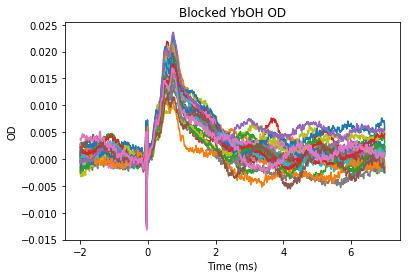

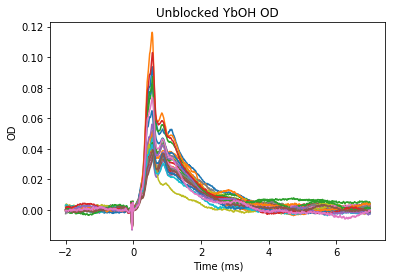

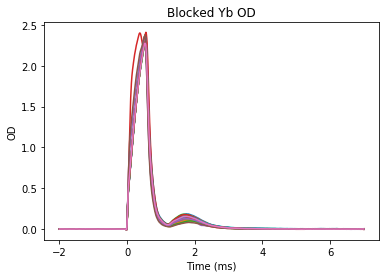

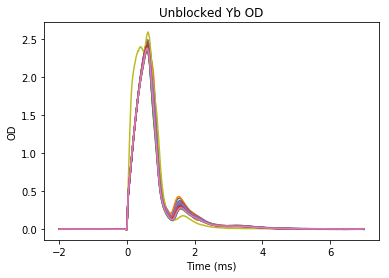

In [29]:
r0=widgets.HBox([folder_path_w])
r1 = widgets.HBox([start_num_w,stop_num_w])
r2 = widgets.HBox([rawdata_lb,print_w])
r3 = widgets.HBox([calcODs_lb,print_w])
widgets.VBox([r0,r1,r2,r3])

A Jupyter Widget

Integrating and processing ODs from  20181213


A Jupyter Widget

Done


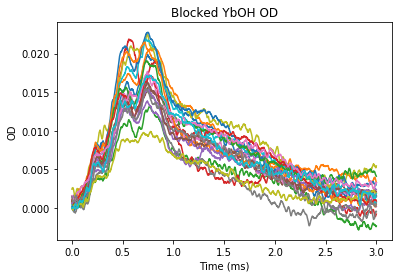

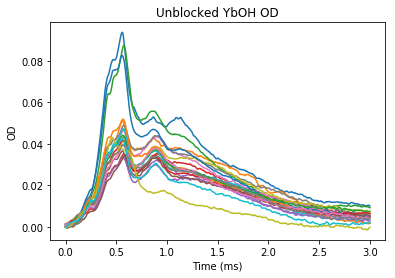

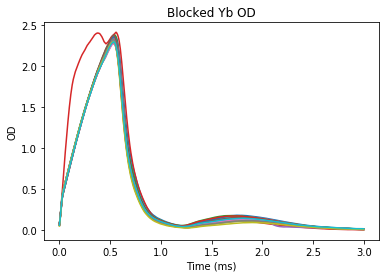

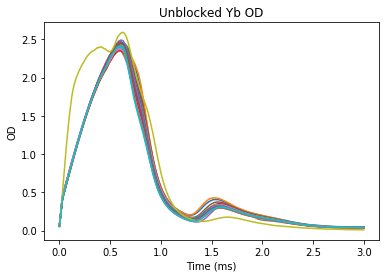

Integrating and processing ODs from  20181213


A Jupyter Widget

Done


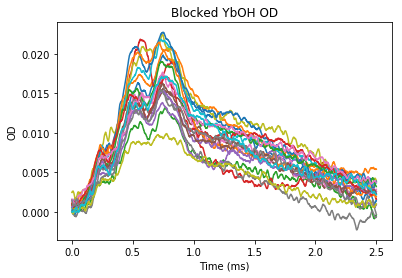

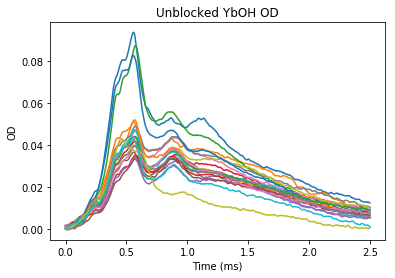

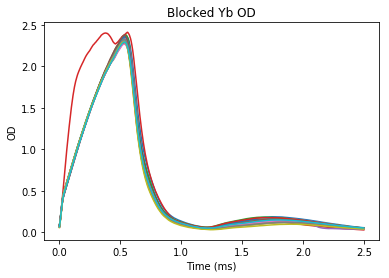

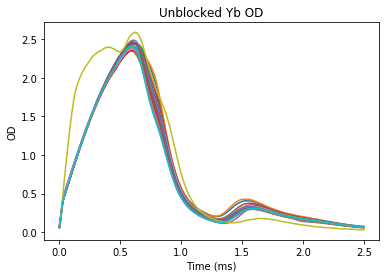

In [30]:
r4 = widgets.HBox([start_int_w,stop_int_w])
r5 = widgets.HBox([intODs_lb,print_w])
widgets.VBox([r4,r5])

In [34]:
data = intODs_lb.value

In [35]:
freq=np.array(data[2])
enhancement_YbOH=data[0]
enhancement_Yb=data[1]

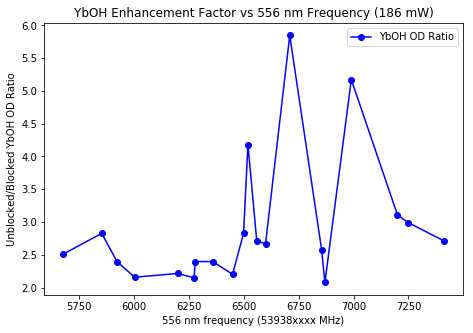

In [36]:
plt.figure(figsize=(7.5,5))
plt.plot(freq,enhancement_YbOH,'bo-',label='YbOH OD Ratio')
plt.title('YbOH Enhancement Factor vs 556 nm Frequency (186 mW)')
plt.xlabel('556 nm frequency (53938xxxx MHz)')
plt.ylabel('Unblocked/Blocked YbOH OD Ratio')
#params = fitGaussian(freq_556,enhancement_YbOH,guess = [50,6500,10,0])
#plt.plot(freq_556,gaussian(freq_556,*params),'y',label='Fit')
plt.legend(loc='best');

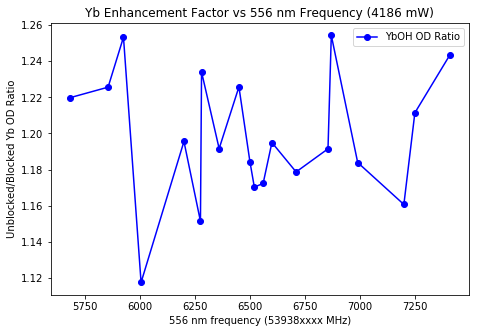

In [180]:
plt.figure(figsize=(7.5,5))
plt.plot(freq_556,enhancement_Yb,'bo-',label='YbOH OD Ratio')
plt.title('Yb Enhancement Factor vs 556 nm Frequency (4186 mW)')
plt.xlabel('556 nm frequency (53938xxxx MHz)')
plt.ylabel('Unblocked/Blocked Yb OD Ratio')
#params = fitGaussian(freq_556,enhancement_Yb,guess = [100,6100,2,0])
#plt.plot(freq_556,gaussian(freq_556,*params),'y',label='Fit')
plt.legend(loc='best');

In [34]:
t = True

In [35]:
t = False

In [36]:
not t

True

In [37]:
if not t:
    print('h')

h
